# Utils

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [18]:
import pickle

def get_tree_dict(pickle_path):
    try: 
        with open(pickle_path, 'rb') as file:
            tree = pickle.load(file)
            return tree
    except:
        print("Can't open file!")

In [19]:
def get_root_id(tree_dict):
    for key, item in tree_dict.items():
        if item['pnode_id'] == -1:
            root_id = key
    return root_id

In [20]:
import treelib

def visualize_rst_tree(tree_dict, root_id, edu_list, new_relation=False, get_edu_text=False):
    rst_tree = treelib.Tree()
    relation_key = 'relation' if not new_relation else 'new_relation'
    node_list = [root_id]

    while node_list:
        id = node_list.pop()
        node = tree_dict[id]
        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None):
            node_text = " EDU " + str(node['edu_span'])
            if get_edu_text:
                node_text += ": " + edu_list[node['edu_span'][0] - 1]
            rst_tree.create_node(node_text, id, parent=node['pnode_id'])
        else:
            node_text = node['node_form']

            if node['node_form'] == 'NN':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'NS':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'SN':
                node_text += "-" + tree_dict[node['lnode_id']][relation_key]
            else:
                raise ValueError("Unrecognized N-S form")
            
            if rst_tree.get_node(node['pnode_id']) is not None:
                rst_tree.create_node(node_text, id, parent=node['pnode_id'])
            else:
                rst_tree.create_node(node_text, id)
                print("\nNo parent at node: ", node_text, '\n')

        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])

    return rst_tree

In [21]:
def get_edus_from_file(edu_path):
    """Get EDUs from .edu file and return a list of EDUs
    """
    edus = []
    try: 
        with open(edu_path, 'r') as file:
            for line in file:
                if not line.strip():
                    continue
                edus.append(line.rstrip('\n'))
        return edus    
    except FileNotFoundError:
        print("Error: File not found!")


In [22]:
def extract_segments(edu_list, tree_dict, root_id): # use this when unpickling
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        edu_list: list containing EDUs (list)
        tree_dict: dict containing tree (dict)

    Return:
        Dict containing text of nucleus, satellite, and original relation from StageDP (dict)
    """

    segments = {'pnode_id': [], 'nucleus': [], 'satellite': [], 'original_relation': []} # if multi-nuclear, satellite represent second nucleus
    node_list = [root_id]
    while node_list:
        id = node_list.pop()
        node = tree_dict[id]

        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None): # node is EDU
            continue
    
        left_edu_span = tree_dict[node['lnode_id']]['edu_span'] # tuple: (from, to)
        right_edu_span = tree_dict[node['rnode_id']]['edu_span'] # tuple: (from, to)
        
        # get corresponding text segments
        left_segment = ""
        for edu in range(left_edu_span[0], left_edu_span[1] + 1):
            left_segment += edu_list[edu - 1].strip() + ' '

        right_segment = ""
        for edu in range(right_edu_span[0], right_edu_span[1] + 1):
            right_segment += edu_list[edu - 1].strip() + ' '

        if node['node_form'] == 'NN':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'NS':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'SN':
            nucleus = right_segment
            satellite = left_segment
            relation = tree_dict[node['lnode_id']]['relation']

        segments['nucleus'].append(nucleus)
        segments['satellite'].append(satellite)
        segments['original_relation'].append(relation)
        segments['pnode_id'].append(id)  
        
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])
        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
    
    return segments

In [23]:
import copy
def add_new_relations_to_tree_dict(tree_dict, new_relations):
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        tree_dict: dict containing tree (dict)
        new_relations: df containing parent id and new relations (and other components no considered in this method)

    Return:
        New modified tree_dict according to new relations identified
    """
    tree_dict_c = copy.deepcopy(tree_dict)
    for _, r in new_relations.iterrows():
        p_id = r['pnode_id']
        rel = r['new_relation']
        if tree_dict_c[p_id]['node_form'] == 'NN':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'NS':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'SN':
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        
    return tree_dict_c 

In [24]:
def write_to_text_file(text_path, text):
    """Write string in text to text_path. The text is to be analyzed using RST and generated questions from. 

    Args:
        text_path (str): path of file to write to
        text (str): text to write to (informational text to extract questions from)
    """

    try:
        with open(text_path, 'w') as f:
            f.write(text)
    except:
        print("Can't open text file!\n")

In [15]:
# run this cell to start processing text

raw_original_text = """Machine learning (ML) is a branch of artificial intelligence (AI) and computer science that focuses on the using data and algorithms to enable AI to imitate the way that humans learn, gradually improving its accuracy.
How does machine learning work?
UC Berkeley (link resides outside ibm.com) breaks out the learning system of a machine learning algorithm into three main parts.

A Decision Process: In general, machine learning algorithms are used to make a prediction or classification. Based on some input data, which can be labeled or unlabeled, your algorithm will produce an estimate about a pattern in the data.
An Error Function: An error function evaluates the prediction of the model. If there are known examples, an error function can make a comparison to assess the accuracy of the model.
A Model Optimization Process: If the model can fit better to the data points in the training set, then weights are adjusted to reduce the discrepancy between the known example and the model estimate. The algorithm will repeat this iterative “evaluate and optimize” process, updating weights autonomously until a threshold of accuracy has been met. 

Machine learning versus deep learning versus neural networks
Since deep learning and machine learning tend to be used interchangeably, it’s worth noting the nuances between the two. Machine learning, deep learning, and neural networks are all sub-fields of artificial intelligence. However, neural networks is actually a sub-field of machine learning, and deep learning is a sub-field of neural networks.

The way in which deep learning and machine learning differ is in how each algorithm learns. "Deep" machine learning can use labeled datasets, also known as supervised learning, to inform its algorithm, but it doesn’t necessarily require a labeled dataset. The deep learning process can ingest unstructured data in its raw form (e.g., text or images), and it can automatically determine the set of features which distinguish different categories of data from one another. This eliminates some of the human intervention required and enables the use of large amounts of data. You can think of deep learning as "scalable machine learning" as Lex Fridman notes in this MIT lecture (link resides outside ibm.com).

Classical, or "non-deep," machine learning is more dependent on human intervention to learn. Human experts determine the set of features to understand the differences between data inputs, usually requiring more structured dat
o learn.

Neural networks, or artificial neural networks (ANNs), are comprised of node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network by that node. The “deep” in deep learning is just referring to the number of layers in a neural network. A neural network that consists of more than three layers—which would be inclusive of the input and the output—can be considered a deep learning algorithm or a deep neural network. A neural network that only has three layers is just a basic neural network.

Deep learning and neural networks are credited with accelerating progress in areas such as computer vision, natural language processing, and speech recognition.

Machine learning methods
Machine learning models fall into three primary categories.

Supervised machine learning            
Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. As input data is fed into the model, the model adjusts its weights until it has been fitted appropriately. This occurs as part of the cross validation process to ensure that the model avoids overfitting or underfitting. Supervised learning helps organizations solve a variety of real-world problems at scale, such as classifying spam in a separate folder from your inbox. Some methods used in supervised learning include neural networks, naïve bayes, linear regression, logistic regression, random forest, and support vector machine (SVM).

Unsupervised machine learning
Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets (subsets called clusters). These algorithms discover hidden patterns or data groupings without the need for human intervention. This method’s ability to discover similarities and differences in information make it ideal for exploratory data analysis, cross-selling strategies, customer segmentation, and image and pattern recognition. It’s also used to reduce the number of features in a model through the process of dimensionality reduction. Principal component analysis (PCA) and singular value decomposition (SVD) are two common approaches for this. Other algorithms used in unsupervised learning include neural networks, k-means clustering, and probabilistic clustering methods.

Semi-supervised learning 
Semi-supervised learning offers a happy medium between supervised and unsupervised learning. During training, it uses a smaller labeled data set to guide classification and feature extraction from a larger, unlabeled data set. Semi-supervised learning can solve the problem of not having enough labeled data for a supervised learning algorithm. It also helps if it’s too costly to label enough data.""" 
raw_original_text = raw_original_text.replace(u"\u2018", "'").replace(u"\u2019", "'").replace(u"\u2013", "-").replace(u"\u2014", "-").replace(u"\u201C", "-").replace(u"\u201D", "-") 
text_path = "../parsers-from-github/StageDP_2/data/my_sample/sample"

write_to_text_file(text_path, raw_original_text)

In [26]:
len(raw_original_text.split())

852

In [29]:
# run this cell to process new data, adjust paths if necessary

pickle_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.pickle"
edu_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.edus"

tree_dict = get_tree_dict(pickle_path)
root_id = get_root_id(tree_dict)
edus = get_edus_from_file(edu_path)
rst_tree = visualize_rst_tree(tree_dict, root_id, edus, get_edu_text=True)

# print(rst_tree.show(stdout=False, sorting=False)) # uncomment to visualize RST tree
# print(edus)

segments = extract_segments(edus, tree_dict, root_id)
df = pd.DataFrame(segments)
df.shape


No parent at node:  NS-Elaboration 



(90, 4)

In [30]:
# assembly the whole piece of text from EDUs, to ensure allignment

original_text = ""
for edu in edus:
    original_text += edu.strip() + ' '

In [31]:
# map "Comparison" to "Join" since GUM does not contain "Comparison"
for row in df[df['original_relation'] == 'Comparison'].iterrows():
    df.at[row[0], 'original_relation'] = "Joint"

# Relation Labeller

In [32]:
# run this cell only once
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "output_train_all_with_additional_reverse_dataset1/checkpoint-45000"
if 'tokenizer' not in locals(): # prevent accidental re-run of cell
    tokenizer = AutoTokenizer.from_pretrained(model_path)

if 'model' not in locals(): # prevent accidental re-run of cell
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(torch.device('cuda'))

Preprocess Data

In [33]:
# get labels
from sklearn.preprocessing import LabelEncoder
label_text = ['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment']

label_shorthand = ['Attr', 'Bckg', 'Cause', 'Cond', 'Contst',
       'Elab', 'Enab', 'Eval', 'Expl', 'Joint',
       'Man-Mean', 'Same-Un', 'Sum', 'Temp',
       'Text-Org', 'Top-Chang', 'Top-Com']

le = LabelEncoder()
le.fit(label_text)
labels = le.transform(df.original_relation)

In [34]:
# adding <sep> token between nucleus and satellite
separation_token = "[SEP]"
input_sentences = df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)

In [35]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text in input_sentences:
    datapoint = {'text': text}
    data.append(datapoint)
data = np.array(data)

In [36]:
# tokenize
import datasets

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True, return_tensors='pt')

# Inference

Batch Inference

In [37]:
device = 'cuda'
model.to(device)
model.eval()

batch_size = 32
dataset = datasets.Dataset.from_list(list(data))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

pred_labels = []

with torch.no_grad():
    for batch in dataloader:
        tokens = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt').to(device)
        output = model(**tokens)
        logits = torch.Tensor.cpu(output.logits)
        pred_labels.extend(np.argmax(logits, axis=-1).tolist())

In [38]:
preds = le.inverse_transform(pred_labels)
df['new_relation'] = preds

In [39]:
# calculate porportion of changed labels

diff = df.apply(lambda x: x['original_relation'] != x['new_relation'], axis=1)
print(diff.sum(), "changed relations out of", df.shape[0], '(' + str(round(float(diff.sum()/df.shape[0]), 2)) + ')')
df[diff]

47 changed relations out of 90 (0.52)


pnode_id  \
0   140222578434288   
1   140222578434624   
2   140222578435128   
3   140222578435072   
4   140222578435352   
6   140222578434176   
7   140222578435464   
9   140222578434344   
10  140222578435296   
11  140222578434400   
12  140222578434904   
13  140222578434960   
14  140222578388384   
17  140222578388272   
19  140222578387936   
28  140222578388104   
29  140222578388720   
31  140222578388832   
33  140222578387208   
34  140222578387376   
35  140222578385248   
36  140222578388328   
40  140222578387152   
42  140222578387040   
43  140222578384968   
44  140222578387488   
45  140222578386592   
46  140222578385416   
47  140222578387992   
54  140222578388664   
55  140222578385864   
57  140222578386704   
58  140222578387600   
59  140222578388216   
60  140222578386144   
61  140222578387264   
62  140222578385304   
63  140222578386312   
65  140222578387768   
66  140222578386368   
73  140222578386536   
74  140222578385920   
75  140222578386984   
77  140222578386760   
84  140222578385584   
88  140222578360216   
89  140222578360160   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                nucleus  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [40]:
# fix old tree with new relations

new_tree_dict = add_new_relations_to_tree_dict(tree_dict, df)
new_rst_tree = visualize_rst_tree(new_tree_dict, get_root_id(new_tree_dict), edus, new_relation=True, get_edu_text=True)

print(new_rst_tree.show(stdout=False, sorting=False)) # for visualizing rst_tree


No parent at node:  NS-Background 

NS-Background
├── NS-Elaboration
│   ├──  EDU (1, 1): Machine learning (ML) is a branch of artificial intelligence (AI) and computer science
│   └── NS-Manner-Means
│       ├── NS-Elaboration
│       │   ├──  EDU (2, 2): that focuses on the using data and algorithms
│       │   └──  EDU (3, 3): to enable AI to imitate the way that humans learn,
│       └──  EDU (4, 4): gradually improving its accuracy.
└── NN-Textual-Organization
    ├──  EDU (5, 5): How does machine learning work?
    └── NN-Textual-Organization
        ├──  EDU (6, 6): UC Berkeley (link resides outside ibm.com) breaks out the learning system of a machine learning algorithm into three main parts.
        └── NS-Textual-Organization
            ├──  EDU (7, 7): A Decision Process:
            └── NN-Elaboration
                ├── NS-Elaboration
                │   ├── NS-Enablement
                │   │   ├──  EDU (8, 8): In general, machine learning algorithms are used
           

<BarContainer object of 13 artists>

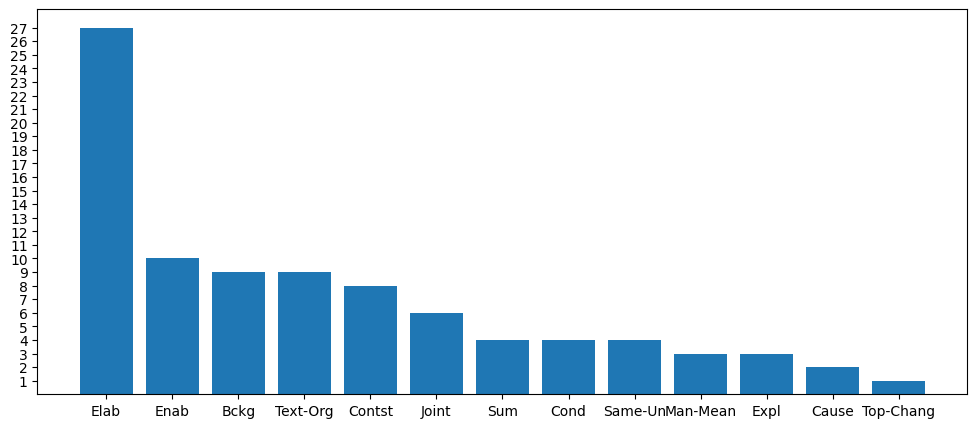

In [41]:
label_cnt = pd.Series(pred_labels).value_counts()
indices = pd.Series(label_shorthand).reindex(label_cnt.index, fill_value=0)

plt.figure(figsize=(12, 5))
plt.yticks(np.arange(1, max(label_cnt) + 1))
plt.bar(indices, label_cnt)

In [42]:
# find occurences of a specific relation

df[df["original_relation"] == "Cause"]

,pnode_id,nucleus,satellite,original_relation,new_relation
31,140222578388832,This method's ability to discover similarities and differences in information,"make it ideal for exploratory data analysis, cross-selling strategies, customer segmentation, and image and pattern recognition.",Cause,Same-Unit
63,140222578386312,"Human experts determine the set of features to understand the differences between data inputs,",usually requiring more structured data to learn.,Cause,Elaboration


In [43]:
# find occurences of a specific relation

df[df["new_relation"] == "Contrast"]

,pnode_id,nucleus,satellite,original_relation,new_relation
9,140222578434344,"If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network.","Otherwise, no data is passed along to the next layer of the network by that node. The -deep- in deep learning is just referring to the number of layers in a neural network. A neural network that consists of more than three layers -which would be inclusive of the input and the output- can be considered a deep learning algorithm or a deep neural network. A neural network that only has three layers is just a basic neural network. Deep learning and neural networks are credited with accelerating progress in areas such as computer vision, natural language processing, and speech recognition. Machine learning methods Machine learning models fall into three primary categories. Supervised machine learning Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. As input data is fed into the model, the model adjusts its weights until it has been fitted appropriately. This occurs as part of the cross validation process to ensure that the model avoids overfitting or underfitting. Supervised learning helps organizations solve a variety of real-world problems at scale, such as classifying spam in a separate folder from your inbox. Some methods used in supervised learning include neural networks, naive bayes, linear regression, logistic regression, random forest, and support vector machine (SVM). Unsupervised machine learning Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets (subsets called clusters). These algorithms discover hidden patterns or data groupings without the need for human intervention. This method's ability to discover similarities and differences in information make it ideal for exploratory data analysis, cross-selling strategies, customer segmentation, and image and pattern recognition. It's also used to reduce the number of features in a model through the process of dimensionality reduction. Principal component analysis (PCA) and singular value decomposition (SVD) are two common approaches for this. Other algorithms used in unsupervised learning include neural networks, k-means clustering, and probabilistic clustering methods. Semi-supervised learning Semi-supervised learning offers a happy medium between supervised and unsupervised learning. During training, it uses a smaller labeled data set to guide classification and feature extraction from a larger, unlabeled data set. Semi-supervised learning can solve the problem of not having enough labeled data for a supervised learning algorithm. It also helps if it's too costly to label enough data.",Elaboration,Contrast
10,140222578435296,"Otherwise, no data is passed along to the next layer of the network by that node.","The -deep- in deep learning is just referring to the number of layers in a neural network. A neural network that consists of more than three layers -which would be inclusive of the input and the output- can be considered a deep learning algorithm or a deep neural network. A neural network that only has three layers is just a basic neural network. Deep learning and neural networks are credited with accelerating progress in areas such as computer vision, natural language processing, and speech recognition. Machine learning methods Machine learning models fall into three primary categories. Supervised machine learning Supervised learning, also known as supervised machine learning, is defined by its use of labeled datasets to train algorithms to classify data or predict outcomes accurately. As input data is fed into the model, the model adjusts its weights until it has been fitted appropriately. This occurs as part of the cross validat

Helper Block

In [44]:
import spacy
from spacy import displacy
if 'nlp' not in locals(): # prevent accidental re-run of cell
    nlp = spacy.load('en_core_web_trf')

sent = "I am happy to see you."
doc = nlp(sent)
displacy.render(doc, style="dep")

In [45]:
for token in doc:
    print(token.tag_, '-', token.text, '-', token.ent_type_ , '-', token.dep_)

PRP - I -  - nsubj
VBP - am -  - ROOT
JJ - happy -  - acomp
TO - to -  - aux
VB - see -  - xcomp
PRP - you -  - dobj
. - . -  - punct


In [46]:
for chunk in doc.noun_chunks:
    print(chunk.root, '-', chunk)

I - I
you - you


In [47]:
spacy.explain('advcl')
# , 'ccomp', 'advcl', 'xcomp'

'adverbial clause modifier'

End Helper Block

Individual Inference

In [48]:
device = 'cuda'
model.to(device)
model.eval()

sep = tokenizer.sep_token
text_n = "She used the tool in the garden, "
text_s = "in order to win."
text = text_n + sep + text_s

with torch.no_grad():
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    output = model(**tokens)
    logits = torch.Tensor.cpu(output.logits)
    single_pred = int(np.argmax(logits, axis=-1))
    
le.inverse_transform([single_pred])[0]

'Enablement'

# Question Generation

Utils

In [49]:
RELATIVE_PRONOUNS = ['who', 'that', 'whose', 'which']

In [50]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_trf')
nlp_small = spacy.load("en_core_web_sm")

In [51]:
def get_subj(clause, accept_pron=True, accept_expl=False):
    """Return subject of clause, None of none found

    Args:
        clause (str): 
        accept_expl (bool, optional): If take expletive as subject. Defaults to False.
        accept_expl (bool, optional): If take pronoun as subject. Defaults to True.

    Returns:
        str: The subject
    """
    doc = nlp(clause)

    for token in doc:
        if 'nsubj' in token.dep_:
            if token.pos_ == "PRON" and not accept_pron:
                continue
            for chunk in doc.noun_chunks:
                if chunk.start <= token.i and token.i < chunk.end:
                    return chunk.text
        if accept_expl:
            if 'expl' in token.dep_:
                return token.text
    return None

In [52]:
# WORKING: make a more fool proof method of checking relative clause: inputing both source sents and text, and use pos tags to determine, refer to : is_dependent_clause()
def check_relative_clause(text):
    """Return if the text (has to contain only one clause) is a relative clause, 
    relative clauses can start with "which", "Ving, "Ved" (not including adverbial clause)

    Args:
        text
    Return
        boolean
    """
    doc = nlp(text)

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.dep_ == "nsubj"):
                if (token.text.lower() in RELATIVE_PRONOUNS):
                    return 1 # relative clause starting with relative pronouns
                break

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']):
                # WORKING: Change way to check tense, use tag_ instead of morph
                if len(token.morph.get('Tense')) == 0:
                    return 0 # not relative clause
                if (token.text.endswith('ing')) or (token.tag_ ==  'VBN'):
                    return 2 # shortened relative clause (ending with Ving or Ved)
            else: 
                return 0

In [53]:
def find_boundary(sent_doc, text_doc):
    """Find boundary indices of text_doc in sent_doc (given that text_doc is in sent_doc)

    Args:
        sent_doc (nlp Doc): 
        text_doc (nlp Doc): 
    """
    start_ind = 0
    while start_ind < len(sent_doc):
        if text_doc.text not in sent_doc[start_ind:].text:
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sent_doc)
    while end_ind > 0:
        if (text_doc.text not in sent_doc[:end_ind].text) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    return start_ind, end_ind

def is_dependent_clause(src_sent, text):
    # WORKING: may use this way to check relative clause as well
    sent_doc = nlp(src_sent)
    text_doc = nlp(text)   

    start_ind, end_ind = find_boundary(sent_doc, text_doc)
    if start_ind < 0 or end_ind > len(sent_doc):
        print("\nText not found in source sentence!\n")
        return None

    for token in sent_doc[start_ind:end_ind]:
        if token.dep_ in ['acl', 'advcl', 'xcomp']: # omitted "ccomp", put back again if needed
            if token.head.i in range(start_ind, end_ind):
                return False
            return True
    return False     

In [54]:
import inflect
p = inflect.engine()

def unshorten_relative_clause(original_sent, clause):
    """Unshorten relative clause (make sure it's a relative clause before calling this method) ending with Ving or Ved, convert them to which/who + V

    Args:
        clause (str): relative clause containing Ving or Ved
        original_sent (str): original sentence containing that clause
    Return:
        tuple(str, str): modified clause and source sentence
    """

    clause_doc = nlp(clause)
    text_doc = nlp(original_sent)
    vb = ""

    for token in clause_doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']): # finds Ving or Ved
                vb = token

    for v_token in text_doc:
        # find verb in original sentence
        if v_token.text == vb.text.strip():
            c_i = vb.i
            t_i = v_token.i
            is_verb = True
            while c_i < len(clause_doc) and t_i < len(text_doc):
                if clause_doc[c_i].text.strip() != text_doc[t_i].text.strip():
                    is_verb = False
                    break
                c_i += 1
                t_i += 1
            if is_verb:
                break
    
    pointed_noun = v_token.head
    pointed_noun_chunk = None
    for chunk in text_doc.noun_chunks:
        if chunk.start <= pointed_noun.i and pointed_noun.i < chunk.end:
            pointed_noun_chunk = chunk
    
    if pointed_noun_chunk:
        pointed_root_noun = pointed_noun_chunk.root
    else:
        pointed_root_noun = pointed_noun
    
    rel_pro = "which" 
    # not a fool-proof way to determine if noun is person
    if pointed_root_noun.ent_type_:
        if pointed_root_noun.ent_type_ == "PERSON":
            rel_pro = "who"

    # check plurality of noun/pronoun and conjugate accordingly
    # only applicable for Present Tense, not for past or others
    if pointed_root_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_root_noun.tag_ == "NNS"
    elif "PRON" in pointed_root_noun.pos_:  # pronoun
        plurality = (pointed_root_noun.lemma_ == "we") or (pointed_root_noun.lemma_ == "you") or (pointed_root_noun.lemma_ == "they") or ((pointed_root_noun.lemma_ == "I"))
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = False # temporary solution

    if not plurality:
        if vb.tag_ == 'VBG':
            conj_vb = p.plural_noun(vb.lemma_) # get singular conjugation (plural_noun() method works with verbs too)
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'is'
            conj_vb = aux + ' ' + vb.text
    else:
        if vb.tag_ == 'VGB':
            conj_vb = p.plural_verb(vb.lemma_) # get plural conjugation
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'are'
            conj_vb = aux + ' ' + vb.text

    fixed_clause = clause.replace(vb.text, rel_pro + ' ' +  conj_vb, 1)# replace only the first occurence of the verb
    fixed_sent = original_sent.replace(clause.strip(), fixed_clause.strip(), 1)
    return  (fixed_sent, fixed_clause)

In [55]:
unshorten_relative_clause("I saw Tom walking at midnight", "walking at midnight")

('I saw Tom which walks at midnight', 'which walks at midnight')

In [56]:
# WORKING: Need to handle all types of shortened relative clauses, for now, only Ving and Ved is covered.

In [57]:
def is_one_clause(text, count_relative_clause=True):
    """Check if input text is one clause or multiple.
        NOTE: If not multiple clause, the method returns true, so does not account for the case of not a full clause, just check whether multiple clauses or not, cause a EDU is usually at least a clause semantically. 

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)

    # check how many subjects
    has_subj = False
    for token in doc:
        if "nsubj" in token.dep_:
            if not count_relative_clause:
                if token.text.lower() in ['who', 'whom', 'whose', 'which', 'that']:
                    continue
                if token.head.dep_ in ['relcl', 'acl', 'ccomp']:
                    continue
            if has_subj:
                return False
            else:
                has_subj = True
    return True # not return has_subj, so that even no subject will be 1 clause

In [58]:
def has_aux(sentence):
    """Check if sentence has auxiliary verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "AUX" in token.pos_:
            return True
    return False

In [59]:
auxiliary_shorthand = {
    "'s": "is",
    "'re": "are",
    "'ve": "have",
    "'d": "had",
    "'ll": "will",
    "n't": "not"
}

In [60]:
def move_aux_to_beginning(sentence):
    """Move auxiliary verb to the beginning of sentence (to form question).
    Input one sentence only. Make sure it has aux verb. Make sure sentence starts with subject.
    """
    doc = nlp(sentence)
    aux = ""
    for token in doc:
        if "AUX" in token.pos_:
            aux = token.text
            break
    assert len(aux)

    if aux.strip() in auxiliary_shorthand:
        new_aux = auxiliary_shorthand[aux]
        new_sent = new_aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)
    else:
        new_sent = aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)

    return new_sent

In [61]:
# move aux test run

txt = "The person on the right can be her father, I can do it if not."
if has_aux(txt):
    print(move_aux_to_beginning(txt))

can the person on the right  be her father, I can do it if not.


In [62]:
def has_verb(sentence):
    """Check if sentence has normal verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "VERB" in token.pos_:
            return True
    return False

In [63]:
def choose_and_replace_aux_for_verb(sentence):
    """Put appropriate aux at beginnging of clause 
    """
    doc = nlp(sentence)
    main_verb = None

    for token in doc:
        if "VERB" in token.pos_:
            main_verb = token
            break
            
    if not main_verb:
        print("\nCan't find main verb in", sentence, '!\n')
        return ""
    
    # check plurality
    pointed_noun = main_verb.head
    if pointed_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_noun.tag_ == "NNS"
    elif pointed_noun.pos_.startswith("PRP"):  # pronoun
        plurality = (pointed_noun.lemma_ == "we") or (pointed_noun.lemma_ == "you") or (pointed_noun.lemma_ == "they")
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = True # temporary solution

    # check tense
    tense = "present" if main_verb.tag_ in ['VBZ', 'VBP'] else 'past'
    # get aux
    aux = {
      "present": "do" if plurality else "does",
      "past": "did",
    }.get(tense)

    # replace appropriate auxilary
    new_sent = sentence.replace(main_verb.text, main_verb.lemma_, 1)
    new_sent = aux + ' ' + new_sent

    return new_sent

In [64]:
# move verb test run

txt = "he hit down."
if has_verb(txt):
    print(choose_and_replace_aux_for_verb(txt))

did he hit down.


In [65]:
def remove_ending_special_chars(sentence):
    """Remove ending non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """
    sen_len = len(sentence)
    for i in range(sen_len - 1, -1, -1):
        char = sentence[i]

        # check if the character is a punctuation mark
        if char.isalnum():
            return sentence
        else:
            sentence = sentence[:i]
    return sentence.strip()

In [66]:
def remove_leading_special_chars(sentence):
    """Remove leading non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """

    start_ind = 0
    for i in range(0, len(sentence)):
        char = sentence[i]
        # check if the character is a punctuation mark
        if char.isalnum():
            break
        else:
            start_ind = i + 1

    return sentence[start_ind: ].strip()

In [67]:
import re
def split_into_sentences(text):
    """Split text into sentence

    Args:
        text (str): text to be plited
    Return: 
        list[str]: spit text
    """
    sents = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)", text)
    sents = [sent for sent in sents if len(sent.strip())]
    return sents

In [68]:
def split_into_paras(text, deli):
    paras = text.split(deli)
    paras = [para.strip() for para in paras if len(para.strip()) != 0]
    return paras

In [69]:
def get_para_id(paras, text):
    """Find paragraph index of text

    Args:
        paras (list[str]): list of paragraphs
        text (str): text to find
    Return:
        int: para id, -1 if not found
    """

    for p_i in range(len(paras)):
        if paras[p_i].find(text.strip()) != -1:
            return p_i
    return -1

In [70]:
import math

def find_source_sents(sents, text, span=2):
    """Find the sentences of which the text is a part. 

    Args:
        sents (str): 
        text (str): 
        span (int): span of sentences to the left to return
    """
    start_ind = 0
    while start_ind < len(sents):
        if text not in ''.join(sents[start_ind:]):
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sents) # exclusive
    while end_ind > 0:
        if (text not in ''.join(sents[:end_ind])) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    if (start_ind < 0) or (end_ind > len(sents)):
        print(f"\nCan't find source sentences of {text}\n")
        return None
    
    src_sents = ''.join(sents[max(start_ind - span, 0):end_ind])
    return src_sents

In [71]:
def add_subject_to_relative_clause(original_sent, clause):
    """Find and Prepend (with modifications) the subject of relative clause that does not contain one

    Args:
        original_sent (str): sentence from which the clause is extracted
        clause (str): clause for which to find subject
    Return:
        str: subject
    """
    doc = nlp(original_sent)
    subj = ""
    clause_start_ind = original_sent.find(clause)
    for token in doc:
        if (len(subj)):
            break
        if (token.dep_ in ['relcl', 'acl']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): # relative clause is noun modifier
            for chunk in doc.noun_chunks:
                if token.head.i >= chunk.start and token.head.i < chunk.end:
                    subj = chunk.text
                    break
        
        # WORKING: relative clause is verb/adverb/adjective modifier, not sure if it's necessary tho
        # 'cause adverbial clauses are often in relations that do not require unshortening of clause
        if (token.dep_ in ['advcl', 'ccomp']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): 
            print("\nFound Adverbial Clause\n")
            return None
            # for chunk in doc.noun_chunks:
            #     if token.head.i >= chunk.start and token.head.i < chunk.end:
            #         subj = chunk.text
            #         break
                    
    if not len(subj): # not found subject
        print("\nCan't find subject of", original_sent, "!\n")
        return None         
    
    for token in doc:
        if (token.dep_ == "nsubj") and (token.text.lower() in RELATIVE_PRONOUNS):
            new_clause = clause.replace(token.text, subj) # contains more nuances (where -> in + N, which -> N, who -> N)
            new_sent = original_sent.replace(clause.strip(), new_clause.strip(), 1)
            return new_sent, new_clause

In [72]:
# add subject test run
txt ="For instance, on the MNLI task, the BERT_base accuracy improves by 1.0% when that trains on 1M steps (128,000 words batch size)"
txt_c = "that trains on 1M steps (128,000 words batch size)"
add_subject_to_relative_clause(txt, txt_c)


Found Adverbial Clause



In [73]:
def remove_leading_conjunction(original_sent, text):
    """Remove leading conjunctions from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if "CONJ" not in token.pos_:
            return (original_sent, text)
        conj = token.text
        break

    new_text = text.replace(conj.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [74]:
def remove_leading_adverb(original_sent, text):
    """Remove leading adverb from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if token.pos_ != 'ADV':
            return (original_sent, text)
        adv = token.text
        break

    new_text = text.replace(adv.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [75]:
DISCOURSE_MARKERS = [
  'accordingly', 'additionally', 'afterward', 'also',
  'although', 'as a final point', 'as a result', 'assuming that', 'because', 'this is because'
  'besides', 'but also', 'compared to', 'consequently', 'conversely', 'despite',
  'even though', 'finally', 'first', 'firstly', 'for example', 'for instance',
  'for the purpose of', 'furthermore', 'hence', 'however', 'if', 'importantly',
  'in addition', 'in case', 'in conclusion', 'in contrast', 'by contrast', 'in fact',
  'in order to', 'in other words', 'in the event that', 'in the same way',
  'indeed', 'just as', 'lastly', 'likewise', 'moreover', 'namely',
  'nevertheless', 'next', 'nonetheless', 'not only', 'of course', 'on condition that',
  'on the contrary', 'on the one hand', 'on the other hand', 'otherwise', 'plus', 'previously',
  'provided that', 'second', 'secondly', 'similarly', 'similarly to', 'since',
  'so', 'so that', 'specifically', 'subsequently', 'such as', 'that is to say', 'that is'
  'then', 'therefore', 'third', 'thirdly', 'thus', 'to conclude', 'to illustrate',
  'to put it differently', 'to sum up', 'ultimately', 'undoubtedly', 'unless',
  'while', 'with the aim of', 'yet', 'then', 'and then'
  'as a consequence', 'as a result',
]

In [76]:
import re

def remove_leading_discourse_marker(original_sent, text):
    """Remove leading discourse markers from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """

    discourse_marker = None
    min_pos = len(text)
    for dm in DISCOURSE_MARKERS:
        find_result = text.lower().find(dm)
        if find_result > -1:
            if find_result < min_pos:
                min_pos = find_result
                discourse_marker = dm
            if find_result == min_pos and len(dm) > len(discourse_marker):
                discourse_marker = dm
    
    # check if found marker stand at the beginning of text
        
    if discourse_marker is not None:
        for i in range(0, min_pos):
            if text[i].isalnum() or text[min_pos + len(discourse_marker)].isalnum():
                discourse_marker = None
                break
            
    if not discourse_marker:
        return (original_sent, text)

    pattern = re.compile(discourse_marker, re.IGNORECASE)

    new_text = pattern.sub("", text, 1)
    new_sent = original_sent.replace(text, new_text)
    
    return (new_sent, new_text)

In [77]:
# to be integrated

def replace_substr(text, substring, start_ind, end_ind):
  """Replace part of text with specified index [start_ind, end_ind) with substring
  """
  try:
    assert(len(substring)  == end_ind - start_ind)
  except:
    print('Text:', text, '--', sep='')
    print('Substring:', substring, '--', sep='')

  text_l = list(text)
  text_l[start_ind:end_ind] = list(substring)

  return ''.join(text_l)

In [78]:
def is_in_ref(index, clusters):
    """Check if current index is in one of the references
    
    Args:
        index (int): index to check
        clusters (list(list(tuple))): list of cluster, each cluster containing a list of tuple correponding to indices of the references
    Return:
        tuple (verdict, (start, end), (ref_token_start, ref_token_end)): -1 both index if not found, ref_token is token to relace
    """
    for cluster in clusters:
        for token in cluster:
            if cluster.index(token) == 0:
                continue
            if index >= token[0] and index < token[1]:
                ref_token = (cluster[0][0], cluster[0][1])
                return True, token, ref_token
            
    return False, (-1, -1), (-1, -1)

In [79]:
def check_relative_clause_type(clause):
    """Check which type of relative clause "clause" is: 
    - which + V + clause (present subject is sufficient for being clause)
    - which + V + (not clause)

    Args:
        sent (str): 
        clause (str): 
    Return: 0 or 1, -1 if not relative clause expected (not start with which + V), then it could be an adverbial clause
    """

    doc = nlp(clause.strip())

    i = 0
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" not in token.pos_: 
                return -1
            else:
                break
        i += 1

    i += 1 
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "VERB" not in token.pos_ and "AUX" not in token.pos_: 
                return -1        
            else:
                break
        i += 1
    
    # if reach here, is expected relative clause type (which + V)
    i += 1
    t_i = i # use to this to check subject and not modify i
    while t_i < len(doc):
        token = doc[t_i]
        if 'nsubj' in token.dep_:
            return 0
        t_i += 1

    return 1    

In [80]:
# to be integrated
from fastcoref import FCoref, LingMessCoref
if 'coref_resolver' not in locals(): # prevent accidental re-run of cell
    coref_resolver = LingMessCoref(device='cuda:0')

def resolve_coreference(original_sent, text):
    """Perfrom coreference resolution and replace corresponding text.

    Args:
        original_sent (str): Sentence the text was derived froms
        text (str): Target text
    """

    text_ind = original_sent.find(text) # starting index of text in original text
    coref_preds = coref_resolver.predict(texts=[original_sent])
    coref_clusters = coref_preds[0].get_clusters(as_strings=False)
    new_sent = []
    new_text = []

    # interate string left to right while appending current char to a new list
    # if current index in one of the token in one of the clusters, add the replacement to the list, keep the text intact, to know what index are at
    i = 0

    # if referred word is a verb, use have to notice and discard the sentence.
    while i < len(original_sent):
        find_result = is_in_ref(i, coref_clusters)
        if find_result[0]:
            token = find_result[1]
            token_ref = find_result[2]
            new_sent.append(original_sent[token_ref[0]:token_ref[1]])
            if (i >= text_ind and i < text_ind + len(text)):
                if (text_ind <= token[0] and token[1] <= text_ind + len(text)):
                    new_text.append(original_sent[token_ref[0]:token_ref[1]])
                else:
                    new_text.append(original_sent[i:text_ind + len(text)])
            i = token[1]
        else:
            new_sent.append(original_sent[i])
            if i >= text_ind and i < text_ind + len(text):
                new_text.append(original_sent[i])
            i += 1

    return ''.join(new_sent), ''.join(new_text)

05/19/2024 20:55:22 - INFO - 	 missing_keys: []
05/19/2024 20:55:22 - INFO - 	 unexpected_keys: []
05/19/2024 20:55:22 - INFO - 	 mismatched_keys: []
05/19/2024 20:55:22 - INFO - 	 error_msgs: []
05/19/2024 20:55:22 - INFO - 	 Model Parameters: 590.0M, Transformer: 434.6M, Coref head: 155.4M


In [81]:
# coref test run    
txt = "Transformers process input sequences in parallel, making the them highly efficient for training and inference"
# sents = split_into_sentences(original_text)
# src = find_source_sents(sents, txt, 5)
# resolve_coreference(src, txt)
coref_preds = coref_resolver.predict(texts=[txt])
coref_clusters = coref_preds[0].get_clusters(as_strings=False)
coref_preds

05/19/2024 20:55:22 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00,  1.44 examples/s]
05/19/2024 20:55:24 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


[CorefResult(text="Transformers process input sequences in parallel, ...", clusters=[['Transformers', 'them']])]

In [82]:
def preprocessing_pipeline(original_text, text, retain_dm=False, retain_conj=False, retain_adv=False, add_subject_to_rel_clause=False):
    """Tranform raw text into a full clause to be fed to the question generation pipeline

    Args:
        text (str): raw text
    Return:
        (str): full clause from text
    """
    sents = split_into_sentences(original_text)

    # coreferen ce resolution
    src_3_sents = find_source_sents(sents, text, 3)
    src_3_sents, text = resolve_coreference(src_3_sents, text)
    src_sent = find_source_sents(split_into_sentences(src_3_sents), text, 0)

    # removal of irrelavent components
    if not retain_dm:
        src_sent, text = remove_leading_discourse_marker(src_sent, text)    
    if not retain_conj:
        src_sent, text = remove_leading_conjunction(src_sent, text)
    if not retain_adv: 
        src_sent, text = remove_leading_adverb(src_sent, text)
    src_sent = remove_leading_special_chars(src_sent)
    text = remove_leading_special_chars(text)
    # src_3_sents = remove_ending_special_chars(src_3_sents)
    # text = remove_ending_special_chars(text)

    # handle single relative clause
    if is_one_clause(text, count_relative_clause=False):
        cl_type = check_relative_clause(text)
        if cl_type != 0: # is relative clause
            if cl_type == 2:
                print("\nText here: ", src_sent, text)
                src_sent, text = unshorten_relative_clause(src_sent, text)
            if add_subject_to_rel_clause:
                # WORKING: temporary solution before fixing add_subject_to_relative_clause()
                if add_subject_to_relative_clause(src_sent, text):
                    src_sent, text = add_subject_to_relative_clause(src_sent, text)

    return src_sent, text  

In [83]:
unshorten_relative_clause("Training: Transformer models are trained using supervised learning", "using supervised learning.")

('Training: Transformer models are trained using supervised learning',
 'using which is supervised learning.')

In [84]:

unshorten_relative_clause("She was talking to me, a person tackled.", " a person tackled.")

('She was talking to me, a person which is tackled.',
 ' a person which is tackled.')

In [85]:
preprocessing_pipeline("She was talking to me, a person tackled.", " a person tackled.")

05/19/2024 20:55:30 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 152.78 examples/s]
05/19/2024 20:55:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


('She was talking to me, a person tackled.', 'a person tackled.')

# Question Templates

WORKING: 
- Handle non-clause (maybe just keep all, discard "which + V" maybe)
- Handle missing information (two EDUs still don't make a sentence) -> maybe segment longer texts

In [86]:
# output file
output_path = './questions_machine_learning'
sents = split_into_sentences(original_text) # text split into sentences
paras = split_into_paras(raw_original_text, deli='\n\n')

In [87]:
def cause_question_type_0(nucleus, satellite): # WORKING: nucleus cause satellite (but now model interpret both directions, needs fixing)
    """Make question based on CAUSE relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def cause_question_type_1(nucleus, satellite):
    """Make question based on CAUSE relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def cause_question_type_2(nucleus, satellite): 
    """Make question based on CAUSE relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "Why " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_cause_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return cause_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return cause_question_type_1(nucleus, satellite)
    else:
        return ("", "")
    return cause_question_type_2(nucleus, satellite)

In [88]:
# contrast relation: ask what's different between two subjects.
# retain discourse markers
    
def make_contrast_question_with_two_clauses(nucleus, satellite):
    n_subj = get_subj(nucleus)
    s_subj = get_subj(satellite)
   
    if (n_subj is None) or (s_subj is None):
        print("\nCan't find subject!\n")
        return ("", "")
     
    if n_subj.strip().lower() == s_subj.strip().lower():
        print("\nSame subjects for nucleus and satellite!\n")
        return ("", "")
    
    question = "What is the difference between " + n_subj + " and " + s_subj + '?'
    answer = nucleus.strip() + ' ' + satellite.strip()
    return (question, answer)

def generate_contrast_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False) and is_one_clause(satellite, count_relative_clause=False):
        return make_contrast_question_with_two_clauses(nucleus, satellite)
    return ("", "") # more than 1 clause

In [89]:
# condition relation

def condition_question_type_0(nucleus, satellite): 
    """Make question based on condition relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def condition_question_type_1(nucleus, satellite):
    """Make question based on condition relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which conditiond the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def condition_question_type_2(nucleus, satellite): 
    """Make question based on condition relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "In what condition " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_condition_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return condition_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return condition_question_type_1(nucleus, satellite)
        else: # 1 clause, not relative clause 
            return condition_question_type_2(nucleus, satellite)
    else:
        return ("", "")

In [90]:
# enablement relation
# difference to manner-means: enablement encapsulate manner-means, as all means can "enable" the goal,
# but enablement also contains situational aid, an event lead (may not intentionally) to another event
    
# enablement relation

def enablement_question_type_0(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def enablement_question_type_1(nucleus, satellite):
    """Make question based on enablement relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which enablementd the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_2(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "How " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_3(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What can be done " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_enablement_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return enablement_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return enablement_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return enablement_question_type_3(nucleus, satellite)
            return enablement_question_type_2(nucleus, satellite)
    return ("", "")

In [91]:
# Manner-Means relation
    
# manner-means relation
# difference to manner-means: manner-means encapsulate manner-means, as all means can "enable" the goal,
# but manner-means also contains situational aid, an event lead (may not intentionally) to another event
    
# manner-means relation

def means_question_type_0(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def means_question_type_1(nucleus, satellite):
    """Make question based on manner-means relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_2(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "By what method " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_3(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What strategy can be employed " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_means_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return means_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return means_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return means_question_type_3(nucleus, satellite)
            return means_question_type_2(nucleus, satellite)
    return ("", "")

In [92]:
# # WORKING: for questions based on BACKGROUND relation, haven't adapted to new preprocessing pipeline, may not be suitable for question generation

# def make_background_question_with_two_clauses(nucleus, satellite): 
#     question = "Under what circumstance that " + nucleus.strip() + '?'
#     answer = satellite

#     return (question, answer)

# def generate_background_question(original_text, nucleus, satellite):
#     nucleus = preprocessing_pipeline(original_text, nucleus, retain_dm=False, retain_conj=True, retain_adv=True) # NOTE: may not want to retain dm here, 'cause need only the dm between nuc and sate
#     satellite = preprocessing_pipeline(original_text, satellite, retain_dm=False, retain_conj=True, retain_adv=True)
    
#     if nucleus is None or satellite is None:
#         print("\nCan't process nucleus and satellite!\n")
#         return ("", "")
    
#     if is_one_clause(nucleus) and is_one_clause(satellite):
#         return make_background_question_with_two_clauses(nucleus, satellite)
#     else:
#         return make_background_question_with_two_clauses(nucleus, satellite)
#         return ("", "") # other cases, not case with two clauses

In [93]:
# # test run for Background
# rel = 'Background'
# for trip in df[df['new_relation'] == rel].iterrows():
#     with open(output_path, 'a') as f:
#         f.write("\nRELATION: " + rel + '\n')

#         f.write("\nOriginal nucleus: " + trip[1]['nucleus'] + '\n')
#         f.write("Original satellite: " + trip[1]['satellite'] + '\n')
#         f.write('\n')
        
#         ques, ans = generate_background_question(original_text, trip[1]['nucleus'], trip[1]['satellite'])
#         if not ques.strip() or not ans.strip():
#             continue
        
#         f.write("\nQuestion: " + ques + '\n')
#         f.write("Answer: " + ans + '\n')

Individual Question Generator (for random testings)

In [97]:
is_one_clause("This characteristic allows the model to learn the context of a word ", count_relative_clause=True)

False

In [95]:
# miscellaneous test run
nuc = """The model may learn too much about the dataset, """
sate = "which is the condition to overfitting." 
org = nuc + sate

nucleus_pair = preprocessing_pipeline(org, nuc, retain_dm=True, retain_adv=True, retain_conj=True)
satellite_pair = preprocessing_pipeline(org, sate)

if nucleus_pair[1] is None or satellite_pair[1] is None:
    print("Can't process nucleus and satellite!\n")

ques, ans = generate_condition_question(nucleus_pair, satellite_pair)
if not ques.strip() or not ans.strip():
    print("Can't generate questions!\n")
        
print("\nQuestion: " + ques)
print("Answer: " + ans + '\n')

05/19/2024 20:55:30 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 117.09 examples/s]
05/19/2024 20:55:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]
05/19/2024 20:55:31 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 87.26 examples/s]
05/19/2024 20:55:31 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]



Question: What condition is the condition to overfitting.?
Answer: The model may learn too much about the dataset,.



# Complete Incomplete Questions

In [96]:
MAX_INC_SOURCE_LENGTH = 256
MAX_INC_TARGET_LENGTH = 64
INC_PREFIX = "complete incomplete question if it lacks information to be answered:"

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

inc_model_path = "models/t5_base_incomplete_questions_with_answer/checkpoint-3000"
inc_tokenizer = T5Tokenizer.from_pretrained(inc_model_path)
inc_model = T5ForConditionalGeneration.from_pretrained(inc_model_path)

inc_model.to('cuda')

/mnt/e/TOM/HUST/20232/rst-relations-labeller/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [3]:
def complete_question(context, question, answer):
    """Complete question if needed, needs globally available model and tokenizer ("inc_model" and "inc_tokenizer")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        str: new question
    """

    inputs = inc_tokenizer(text=f"{INC_PREFIX} context: {context}, incomplete question: {question}, answer: {answer}",
                        max_length=MAX_INC_SOURCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt').to('cuda')
        
    output_sequences = inc_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_INC_TARGET_LENGTH
    )

    output = inc_tokenizer.batch_decode(output_sequences, skip_special_tokens=True)[-1]
    return output

In [16]:
# test run
question = "Why can computation take a long time?"
answer = "They ompute each component of an input in sequence"
context = """RNNs and LSTM date back to the 1920s and 1990s, respectively. These techniques compute each component of an input in sequence (e.g. word by word), so computation can take a long time. What's more, both approaches run into limitations in retaining context when the “distance” between pieces of information in an input is long."""

new_question = complete_question(context, question, answer)
print(question.strip() != new_question)
print(new_question)

False
Why can computation take a long time?


# Distractors Generation

In [9]:
MAX_SOURCE_LENGTH = 4400
MAX_TARGET_LENGTH = 96
PREFIX = "generate 3 distractors:"

In [55]:
from transformers import AutoTokenizer, T5ForConditionalGeneration, LongT5ForConditionalGeneration

dis_model_path = "models/longt5_base_distractors_with_truncated_QuALITY/checkpoint-2500"
dis_tokenizer = AutoTokenizer.from_pretrained(dis_model_path)
dis_model = LongT5ForConditionalGeneration.from_pretrained(dis_model_path)

dis_model.to('cuda')

LongT5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): LongT5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): LongT5Block(
        (layer): ModuleList(
          (0): LongT5LayerTransientGlobalSelfAttention(
            (TransientGlobalSelfAttention): LongT5TransientGlobalAttention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
              (global_relative_attention_bias): Embedding(32, 12)
              (global_input_layer_norm): LongT5LayerNorm()
            )
            (layer_norm): LongT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): LongT5LayerFF(
            (DenseReluDense

In [56]:
def generate_3_distractors(context, question, answer):
    """Generate 3 distractors, needs globally available model and tokenizer ("dis_tokenizer" and "dis_model")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        (dis1, dis2, dis3)
    """

    inputs = dis_tokenizer(text=f"{PREFIX} context: {context}, question: {question}, answer: {answer}", 
                        max_length=MAX_SOURCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt').to('cuda')
        
    output_sequences = dis_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_TARGET_LENGTH
    )

    output = dis_tokenizer.batch_decode(output_sequences)[-1]
    print(output)
    dis1_pos = output.find("distractor 1:")
    dis2_pos = output.find("distractor 2:")
    dis3_pos = output.find("distractor 3:")
    
    dis1 = output[dis1_pos + len("distractor 1:"):dis2_pos].strip()
    dis2 = output[dis2_pos + len("distractor 2:"):dis3_pos].strip()
    dis3 = output[dis3_pos + len("distractor 3:"):].strip()

    return (dis1, dis2, dis3)

WOKRING: Distractors are still the same

In [ ]:
rel = 'Cause'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_cause_question(nucleus_pair, satellite_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        ques, ans = generate_cause_question(satellite_pair, nucleus_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("Distractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

05/18/2024 19:03:15 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00,  5.09 examples/s]
05/18/2024 19:03:16 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
05/18/2024 19:03:18 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 91.15 examples/s]
05/18/2024 19:03:18 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]



Text here:  Tesco, one of the world's top five retailers has not abandoned Tesco, one of the world's top five retailers traditional retail offering but augmented Tesco, one of the world's top five retailers business with these innovations,  infusing Tesco, one of the world's top five retailers value proposition with a green streak. infusing Tesco, one of the world's top five retailers value proposition with a green streak.
distractor 1: None of the above choices., distractor 2: augmented Tesco, one of the world's top five retailers business with these innovations,., distractor 3: augmented Tesco, one of the world's top five retailers business with these innovations.


05/18/2024 19:03:23 - INFO - 	 Tokenize 1 inputs...


distractor 1: None of the above choices., distractor 2: which infuses Tesco, one of the world's top five retailers value proposition with a green streak., distractor 3: which infuses Tesco, one of the world's top five retailers value proposition with a green streak.


Map: 100%|██████████| 1/1 [00:00<00:00, 91.95 examples/s]
05/18/2024 19:03:23 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]
05/18/2024 19:03:23 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 83.91 examples/s]
05/18/2024 19:03:23 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


05/18/2024 19:03:30 - INFO - 	 Tokenize 1 inputs...


distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


Map: 100%|██████████| 1/1 [00:00<00:00, 97.90 examples/s]
05/18/2024 19:03:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]
05/18/2024 19:03:30 - INFO - 	 Tokenize 1 inputs...



Text here:  Using these insights, The Coach brand launched the lower-priced Poppy handbags, which were in vibrant colors, and looked more youthful and playful than conventional The Coach brand products. Using these insights, The Coach brand launched the lower-priced Poppy handbags, which were in vibrant colors, and looked more youthful and playful than conventional The Coach brand products.


Map: 100%|██████████| 1/1 [00:00<00:00, 101.71 examples/s]
05/18/2024 19:03:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



Text here:  Creating the sub-brand allowed they to avert an across-the-board price cut. In contrast to the many companies that responded to the recession by cutting prices, they saw the new consumer mindset as an opportunity for innovation and renewal. Creating the sub-brand allowed they to avert an across-the-board price cut. In contrast to the many companies that responded to the recession by cutting prices, they saw the new consumer mindset as an opportunity for innovation and renewal.
distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


05/18/2024 19:03:36 - INFO - 	 Tokenize 1 inputs...


distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


Map: 100%|██████████| 1/1 [00:00<00:00, 95.33 examples/s]
05/18/2024 19:03:36 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
05/18/2024 19:03:37 - INFO - 	 Tokenize 1 inputs...



Text here:  Creating the sub-brand allowed they to avert an across-the-board price cut. Creating the sub-brand allowed they to avert an across-the-board price cut.


Map: 100%|██████████| 1/1 [00:00<00:00, 55.20 examples/s]
05/18/2024 19:03:37 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.
distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


In [ ]:
rel = 'Explanation'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_cause_question(nucleus_pair, satellite_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        ques, ans = generate_cause_question(satellite_pair, nucleus_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("Distractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

05/18/2024 19:03:43 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 20.17 examples/s]
05/18/2024 19:03:43 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
05/18/2024 19:03:45 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 76.44 examples/s]
05/18/2024 19:03:45 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


distractor 1: The ME2, a video game created by Canada's iToys, was a game that was designed to be played on a handheld device., distractor 2: The ME2, a video game created by Canada's iToys was designed to be played on a handheld device., distractor 3: The ME2, a video game created by Canada's iToys was designed to be played on a handheld device.
distractor 1: None of the above choices., distractor 2:, distractor 3:


In [ ]:
# test run for Contrast
rel = 'Contrast'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite, retain_dm=True, retain_adv=True, retain_conj=True, add_subject_to_rel_clause=True)
        
        if nucleus_pair[1] is None or nucleus_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_contrast_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            continue
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

05/18/2024 19:03:50 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.40 examples/s]
05/18/2024 19:03:50 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]
05/18/2024 19:03:51 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 109.19 examples/s]
05/18/2024 19:03:51 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]
05/18/2024 19:03:51 - INFO - 	 Tokenize 1 inputs...



Can't find subject!



Map: 100%|██████████| 1/1 [00:00<00:00, 106.38 examples/s]
05/18/2024 19:03:51 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
05/18/2024 19:03:52 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 41.57 examples/s]
05/18/2024 19:03:52 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
05/18/2024 19:03:52 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.87 examples/s]
05/18/2024 19:03:52 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
05/18/2024 19:03:53 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 104.42 examples/s]
05/18/2024 19:03:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
05/18/2024 19:03:53 - INFO - 	 Tokenize 1 inputs...



Can't find subject!



Map: 100%|██████████| 1/1 [00:00<00:00, 78.32 examples/s]
05/18/2024 19:03:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
05/18/2024 19:03:54 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 78.40 examples/s]
05/18/2024 19:03:54 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]
05/18/2024 19:03:54 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.01 examples/s]
05/18/2024 19:03:54 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
05/18/2024 19:03:55 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 89.54 examples/s]
05/18/2024 19:03:55 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
05/18/2024 19:03:55 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 107.

distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


Map: 100%|██████████| 1/1 [00:00<00:00, 98.59 examples/s]
05/18/2024 19:03:59 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]
05/18/2024 19:03:59 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 100.46 examples/s]
05/18/2024 19:03:59 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]
05/18/2024 19:04:02 - INFO - 	 Tokenize 1 inputs...


distractor 1: Coach was able to create a new brand by incorporating the new trends into their existing products. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones. This strategy was a success because it allowed Coach to retain the attributes of its existing products while adding new ones.


Map: 100%|██████████| 1/1 [00:00<00:00, 91.59 examples/s]
05/18/2024 19:04:02 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
05/18/2024 19:04:02 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 165.77 examples/s]
05/18/2024 19:04:02 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


In [ ]:
# for Condition relation

rel = 'Condition'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus[1] is None or satellite[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_condition_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        ques, ans = generate_condition_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

05/18/2024 19:04:03 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 96.64 examples/s]
05/18/2024 19:04:03 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
05/18/2024 19:04:03 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 95.52 examples/s]
05/18/2024 19:04:03 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


distractor 1: None of the above choices., distractor 2: you can't counteract undesired outcomes of a trend, such as associations with unhealthy lifestyles by reaffirming the core values of your category., distractor 3: you can't counteract undesired outcomes of a trend, such as associations with unhealthy lifestyles by reaffirming the core values of your category.


05/18/2024 19:04:10 - INFO - 	 Tokenize 1 inputs...


distractor 1: aspects of your category clash with undesired outcomes of a trend, such as associations with unhealthy lifestyles,., distractor 2: aspects of your category clash with undesired outcomes of a trend, such as associations with unhealthy lifestyles,., distractor 3: aspects of your category clash with undesired outcomes of a trend, such as associations with unhealthy lifestyles,.


Map: 100%|██████████| 1/1 [00:00<00:00, 81.80 examples/s]
05/18/2024 19:04:10 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]
05/18/2024 19:04:10 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 99.59 examples/s]
05/18/2024 19:04:10 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


distractor 1: your innovations need to be reaffirmed by reaffirming the core values of your category., distractor 2: your innovations need to be reaffirmed by reaffirming the core values of your category., distractor 3: your innovations need to be reaffirmed by reaffirming the core values of your category.


05/18/2024 19:04:14 - INFO - 	 Tokenize 1 inputs...


distractor 1: None of the above choices., distractor 2: you are trying to create a new category., distractor 3: you are trying to create a new category.


Map: 100%|██████████| 1/1 [00:00<00:00, 92.35 examples/s]
05/18/2024 19:04:15 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]
05/18/2024 19:04:15 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 105.03 examples/s]
05/18/2024 19:04:15 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


distractor 1: the infuse-and-augment strategy will allow you to reinvigorate your category., distractor 2: the infuse-and-augment strategy will allow you to reinvigorate your category., distractor 3: None of the above choices.
distractor 1: your category basic value proposition is reaffirmed by the trend,., distractor 2: your category basic value proposition is reaffirmed by the trend,., distractor 3: your category basic value proposition is reaffirmed by the trend


In [ ]:
# test run for Enablement
rel = 'Enablement'

with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, retain_conj=True, retain_adv=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
       
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_enablement_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')
        
        ques, ans = generate_enablement_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')
        

05/18/2024 19:04:19 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 97.59 examples/s]
05/18/2024 19:04:19 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]
05/18/2024 19:04:19 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 96.31 examples/s]
05/18/2024 19:04:20 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


distractor 1: The ME2 was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category. It was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category.


05/18/2024 19:04:25 - INFO - 	 Tokenize 1 inputs...


distractor 1: The ME2 was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category. It was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category.


Map: 100%|██████████| 1/1 [00:00<00:00, 118.42 examples/s]
05/18/2024 19:04:25 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
05/18/2024 19:04:25 - INFO - 	 Tokenize 1 inputs...



Text here:  A more radical strategy entails combining aspects of the product's existing value proposition with attributes addressing changes arising from a trend, to create a novel experience - one that may land Tesco in an entirely new market space. addressing changes arising from a trend,


Map: 100%|██████████| 1/1 [00:00<00:00, 101.33 examples/s]
05/18/2024 19:04:25 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


distractor 1: None of the above choices., distractor 2: Nike is a company that is a company that is a company, distractor 3: Nike is a company that is a company
distractor 1: None of the above choices., distractor 2: Nike is a company that is a company that is a company, distractor 3: Nike is a company that is a company


In [ ]:
# test run for Manner-Means
rel = 'Manner-Means'
with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)

        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_means_question(nucleus_pair, satellite_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')
        
        ques, ans = generate_means_question(satellite_pair, nucleus_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
            
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(para, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

05/18/2024 19:04:29 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 101.88 examples/s]
05/18/2024 19:04:29 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
05/18/2024 19:04:30 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 86.31 examples/s]
05/18/2024 19:04:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


distractor 1: by reaffirming the core values of your category., distractor 2: by reaffirming the core values of your category., distractor 3: by reaffirming the core values of your category.


05/18/2024 19:04:35 - INFO - 	 Tokenize 1 inputs...


distractor 1: None of the above choices., distractor 2: you can reaffirm the core values of your category by reaffirming the core values of your category., distractor 3: you can reaffirm the core values of your category by reaffirming the core values of your category.


Map: 100%|██████████| 1/1 [00:00<00:00, 93.19 examples/s]
05/18/2024 19:04:35 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]
05/18/2024 19:04:36 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 98.14 examples/s]
05/18/2024 19:04:36 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


distractor 1: The ME2 was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category. It was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category.


05/18/2024 19:04:41 - INFO - 	 Tokenize 1 inputs...


distractor 1: The ME2 was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category. It was a product that was designed to counteract the negatives of the toy category, and to reaffirm the values associated with the category.


Map: 100%|██████████| 1/1 [00:00<00:00, 88.84 examples/s]
05/18/2024 19:04:41 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
05/18/2024 19:04:41 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 108.12 examples/s]
05/18/2024 19:04:42 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


distractor 1: Nike+ sports kit and web interface were a way to combine and transcend the existing value proposition with attributes addressing changes arising from a trend, distractor 2: Nike+ sports kit and web interface were a way to combine and transcend the existing value proposition, distractor 3: Nike+ sports kit and web interface were a way to combine and transcend the existing value proposition


05/18/2024 19:04:47 - INFO - 	 Tokenize 1 inputs...


distractor 1: Nike+ sports kit and web interface moved Nike from a focus on athletic apparel to a new plane of engagement with its customers, distractor 2: Nike+ sports kit and web interface moved Nike from a focus on athletic apparel to a new plane of engagement with its customers, distractor 3: None of the above choices.


Map: 100%|██████████| 1/1 [00:00<00:00, 94.47 examples/s]
05/18/2024 19:04:47 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
05/18/2024 19:04:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 113.45 examples/s]
05/18/2024 19:04:48 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


distractor 1: None of the above choices., distractor 2: Like points earned on a credit card., distractor 3: Like points earned on a debit card.


05/18/2024 19:04:51 - INFO - 	 Tokenize 1 inputs...


distractor 1: points can be redeemed for a gift card., distractor 2: points can be redeemed for a gift card., distractor 3: None of the above choices.


Map: 100%|██████████| 1/1 [00:00<00:00, 111.20 examples/s]
05/18/2024 19:04:51 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
05/18/2024 19:04:52 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 100.57 examples/s]
05/18/2024 19:04:52 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


distractor 1: by involving consumers in ways that produce intangible results., distractor 2: by involving consumers in ways that produce intangible results., distractor 3: None of the above choices.


05/18/2024 19:04:55 - INFO - 	 Tokenize 1 inputs...


distractor 1: None of the above choices., distractor 2:, distractor 3:


Map: 100%|██████████| 1/1 [00:00<00:00, 131.99 examples/s]
05/18/2024 19:04:55 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]
05/18/2024 19:04:55 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 102.82 examples/s]
05/18/2024 19:04:55 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


distractor 1: by ignoring trends in their innovation strategies., distractor 2: by ignoring trends in their product development strategies., distractor 3: None of the above choices.
distractor 1: None of the above choices., distractor 2: By letting competitors take the lead., distractor 3: By ignoring trends in their innovation strategies.


Individual Inference

In [89]:
context = "Many ignore trends in their innovation strategies or adopt a wait-and-see approach and let competitors take the lead. At a minimum, such responses mean missed profit opportunities. At the extreme, they can jeopardize a company by ceding to rivals the opportunity to transform the industry. The purpose of this article is twofold: to spur managers to think more expansively about how trends could engender new value propositions in their core markets, and to provide some high-level advice on how’ to make market research and product development personnel more adept at analyzing and exploiting trends."
question = "Why can ignore trends in their innovation strategies or adopt a wait-and-see approach and let competitors take the lead jeopardize a company?"
answer = "Because the company then cedes to rivals the opportunity to transform the industry."

dis1, dis2, dis3 = generate_3_distractors(context, ques, ans)
print("\nDistractor 1: " + dis1)
print("Distractor 2: " + dis2)
print("Distractor 3: " + dis3)

distractor 1: None of the above choices., distractor 2: By letting competitors take the lead., distractor 3: By ignoring trends in their innovation strategies.

Distractor 1: None of the above choices.,
Distractor 2: By letting competitors take the lead.,
Distractor 3: By ignoring trends in their innovation strategies.
